# Fuzzy Rain Prediction




## 1. Membership Functions


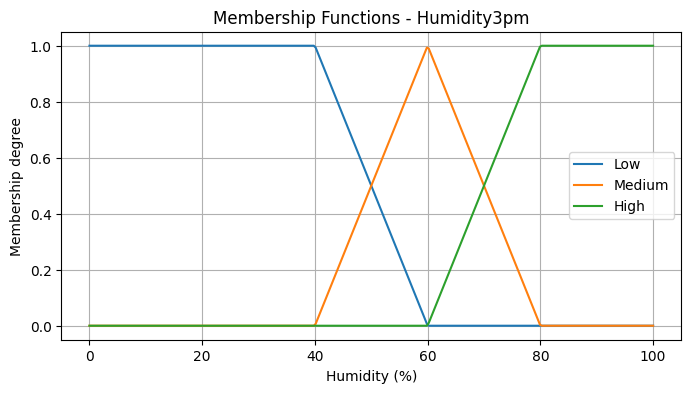

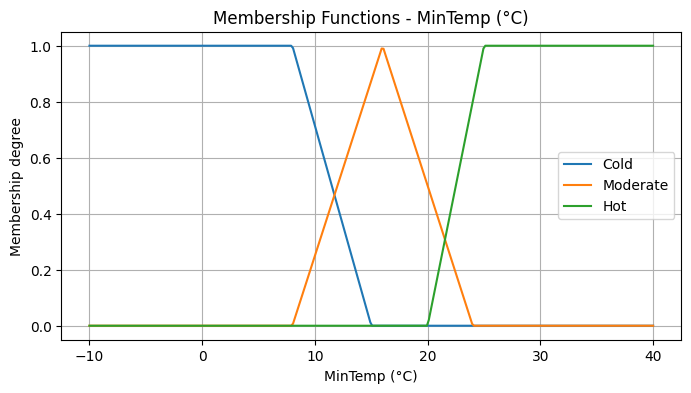

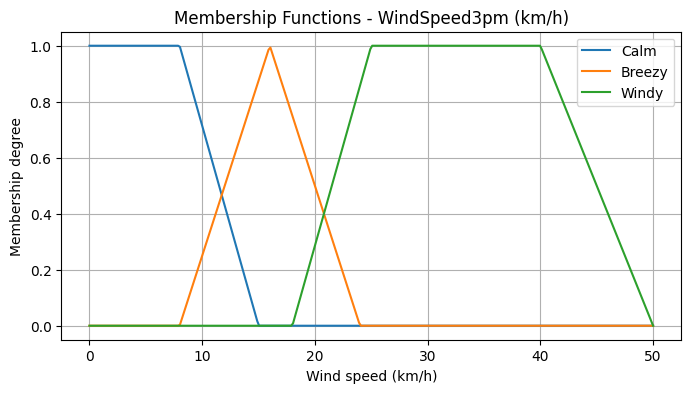

In [1]:
import numpy as np
import matplotlib.pyplot as plt

def trapezoid_mf(x, a, b, c, d):
    x = np.array(x, dtype=float)
    y = np.zeros_like(x, dtype=float)
    if b == a:
        rising = (x >= a) & (x < b + 1e-9)
    else:
        rising = (x >= a) & (x < b)
    if b != a:
        denom = (b - a) if (b - a) != 0 else 1e-9
        y[rising] = (x[rising] - a) / denom
    top = (x >= b) & (x <= c)
    y[top] = 1.0
    if d != c:
        denom2 = (d - c) if (d - c) != 0 else 1e-9
        falling = (x > c) & (x <= d)
        y[falling] = (d - x[falling]) / denom2
    return y

def triangular_mf(x, a, b, c):
    return trapezoid_mf(x, a, b, b, c)

x_h = np.linspace(0,100,300)
hum_low = trapezoid_mf(x_h, 0, 0, 40, 60)
hum_med = triangular_mf(x_h, 40, 60, 80)
hum_high = trapezoid_mf(x_h, 60, 80, 100, 100)
plt.figure(figsize=(8,4))
plt.plot(x_h, hum_low, label='Low')
plt.plot(x_h, hum_med, label='Medium')
plt.plot(x_h, hum_high, label='High')
plt.title('Membership Functions - Humidity3pm')
plt.xlabel('Humidity (%)')
plt.ylabel('Membership degree')
plt.legend()
plt.grid(True)
plt.show()

x_t = np.linspace(-10,40,300)
cold = trapezoid_mf(x_t, -10, -10, 8, 15)
moderate = triangular_mf(x_t, 8, 16, 24)
hot = trapezoid_mf(x_t, 20, 25, 40, 40)
plt.figure(figsize=(8,4))
plt.plot(x_t, cold, label='Cold')
plt.plot(x_t, moderate, label='Moderate')
plt.plot(x_t, hot, label='Hot')
plt.title('Membership Functions - MinTemp (°C)')
plt.xlabel('MinTemp (°C)')
plt.ylabel('Membership degree')
plt.legend()
plt.grid(True)
plt.show()

x_w = np.linspace(0,50,300)
calm = trapezoid_mf(x_w, 0, 0, 8, 15)
breezy = triangular_mf(x_w, 8, 16, 24)
windy = trapezoid_mf(x_w, 18, 25, 40, 50)
plt.figure(figsize=(8,4))
plt.plot(x_w, calm, label='Calm')
plt.plot(x_w, breezy, label='Breezy')
plt.plot(x_w, windy, label='Windy')
plt.title('Membership Functions - WindSpeed3pm (km/h)')
plt.xlabel('Wind speed (km/h)')
plt.ylabel('Membership degree')
plt.legend()
plt.grid(True)
plt.show()


## 2. Rule Base (IF - THEN)



1. IF Humidity is High THEN Rain Likelihood is High  
2. IF Humidity is Medium AND MinTemp is Cold THEN Rain Likelihood is High  
3. IF Humidity is Medium AND MinTemp is Moderate THEN Rain Likelihood is Medium  
4. IF Humidity is Low THEN Rain Likelihood is Low  
5. IF WindSpeed is Windy THEN Rain Likelihood increases slightly



In [2]:
import pandas as pd, numpy as np
sample = pd.read_csv('rain_fuzzy_sample.csv')
# ensure numeric
for c in ['Humidity3pm','MinTemp','WindSpeed3pm']:
    sample[c] = sample[c].astype(float)

# recompute memberships
hum = sample['Humidity3pm'].values
mint = sample['MinTemp'].values
wind = sample['WindSpeed3pm'].values

hum_low = trapezoid_mf(hum, 0, 0, 40, 60)
hum_med = triangular_mf(hum, 40, 60, 80)
hum_high = trapezoid_mf(hum, 60, 80, 100, 100)

cold = trapezoid_mf(mint, -10, -10, 8, 15)
moderate = triangular_mf(mint, 8, 16, 24)
hot = trapezoid_mf(mint, 20, 25, 40, 40)

calm = trapezoid_mf(wind, 0, 0, 8, 15)
breezy = triangular_mf(wind, 8, 16, 24)
windy = trapezoid_mf(wind, 18, 25, 40, 50)

rule1 = hum_high
rule2 = np.minimum(hum_med, cold)
rule3 = np.minimum(hum_med, moderate)
rule4 = hum_low
rule5 = windy * 0.6

low_val = 0.15; med_val = 0.5; high_val = 0.85
numerator = rule1*high_val + rule2*high_val + rule3*med_val + rule4*low_val + rule5*0.6

denominator = rule1 + rule2 + rule3 + rule4 + rule5 + 1e-6
rain_likelihood = numerator / denominator
rain_likelihood = (rain_likelihood - rain_likelihood.min()) / (rain_likelihood.max() - rain_likelihood.min() + 1e-9)

if 'MaxTemp' in sample.columns:
    maxt = sample['MaxTemp'].fillna(sample['MinTemp']+6).values
else:
    maxt = sample['MinTemp'].values + 6

dryness_index = (100 - sample['Humidity3pm'].values) * (maxt / 30.0)
dryness_norm = (dryness_index - dryness_index.min()) / (dryness_index.max() - dryness_index.min() + 1e-9)

sample['Rain_Likelihood_Fuzzy'] = rain_likelihood
sample['Dryness_Index'] = dryness_norm
sample.head(8)


,Date,Location,MinTemp,MaxTemp,Rainfall,Evaporation,Sunshine,WindGustDir,WindGustSpeed,WindDir9am,...,Pressure9am,Pressure3pm,Cloud9am,Cloud3pm,Temp9am,Temp3pm,RainToday,RainTomorrow,Rain_Likelihood_Fuzzy,Dryness_Index
0,2017-06-11,Melbourne,3.4,15.5,0.2,2.0,7.5,SSW,22.0,NE,...,1029.1,1025.5,5.0,7.0,6.1,13.6,No,No,1.000000,0.141355
1,2008-07-16,Canberra,-0.9,12.8,0.2,2.0,1.9,N,17.0,SE,...,1024.1,1020.8,7.0,7.0,2.7,12.1,No,No,1.000000,0.134391
2,2012-07-31,Sydney,7.5,16.1,4.4,3.0,6.3,SW,44.0,W,...,1025.8,1022.9,6.0,6.0,9.9,13.7,Yes,No,0.614556,0.213850
3,2011-02-12,Adelaide,16.4,22.0,12.2,NaN,2.4,SE,43.0,E,...,1021.4,1020.1,NaN,NaN,17.6,20.8,Yes,No,0.371516,0.286317
4,2011-05-05,WaggaWagga,3.1,18.8,0.0,2.4,10.1,SSW,31.0,ENE,...,1023.7,1021.8,1.0,1.0,10.0,18.2,No,No,0.000000,0.380202
5,2011-07-28,Albany,10.4,19.5,1.4,3.0,6.1,NaN,NaN,NNW,...,993.7,995.0,7.0,7.0,17.0,17.8,Yes,Yes,0.801418,0.221257
6,2010-03-03,Portland,14.8,23.2,0.0,5.0,11.3,ENE,35.0,E,...,1019.3,1015.7,8.0,0.0,15.6,22.6,No,No,0.295139,0.314837
7,2016-02-03,Albury,19.8,25.8,0.0,NaN,NaN,SSE,31.0,SW,...,1002.8,1004.4,7.0,8.0,22.4,22.6,No,No,0.850000,0.185551


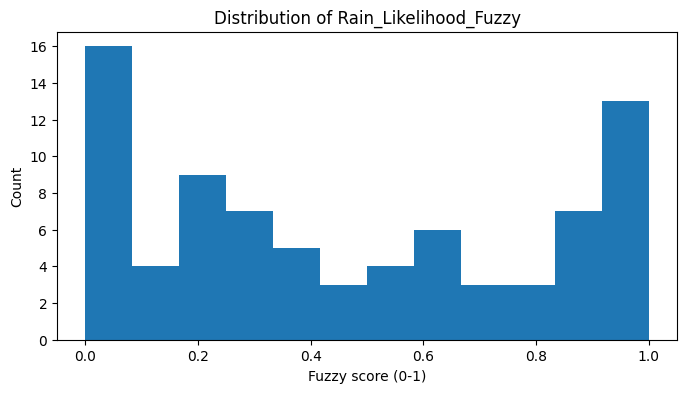

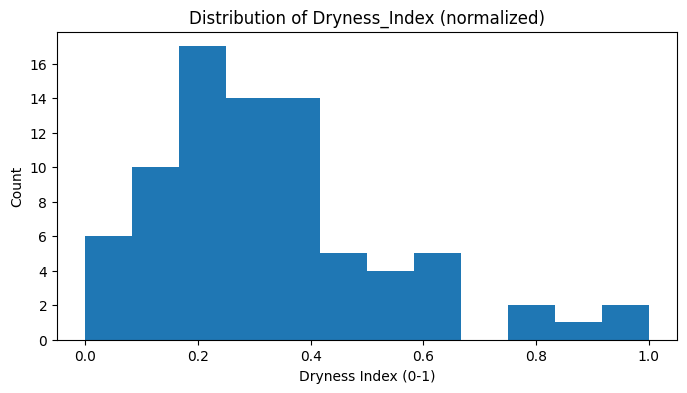

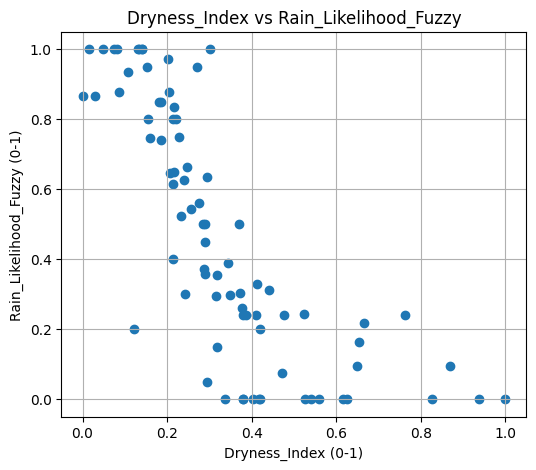

Counts of RainToday:
RainToday
No     65
Yes    14
NaN     1
Name: count, dtype: int64

Average Rain_Likelihood_Fuzzy by RainToday:
RainToday
No     0.433465
Yes    0.651232
Name: Rain_Likelihood_Fuzzy, dtype: float64


In [3]:
import matplotlib.pyplot as plt
plt.figure(figsize=(8,4))
plt.hist(sample['Rain_Likelihood_Fuzzy'], bins=12)
plt.title('Distribution of Rain_Likelihood_Fuzzy')
plt.xlabel('Fuzzy score (0-1)')
plt.ylabel('Count')
plt.show()

plt.figure(figsize=(8,4))
plt.hist(sample['Dryness_Index'], bins=12)
plt.title('Distribution of Dryness_Index (normalized)')
plt.xlabel('Dryness Index (0-1)')
plt.ylabel('Count')
plt.show()

plt.figure(figsize=(6,5))
plt.scatter(sample['Dryness_Index'], sample['Rain_Likelihood_Fuzzy'])
plt.title('Dryness_Index vs Rain_Likelihood_Fuzzy')
plt.xlabel('Dryness_Index (0-1)')
plt.ylabel('Rain_Likelihood_Fuzzy (0-1)')
plt.grid(True)
plt.show()

if 'RainToday' in sample.columns:
    print('Counts of RainToday:')
    print(sample['RainToday'].value_counts(dropna=False))
    print('\nAverage Rain_Likelihood_Fuzzy by RainToday:')
    print(sample.groupby('RainToday')['Rain_Likelihood_Fuzzy'].mean())
